# Sorting ads by partisanship.


## Overview

Our challenge is to take a big corpus of political ads and sort them by partisanship. Democrats, Republicans, non-partisan and commercial (e.g. merch).

I took these ads from Facebook's ad library, and you could apply it maybe to tweets or Google ads too. 

But note that our workflow isn't politics-specific. You could do the exact same thing to categorize court documents... or consumer complaints... or online comments.

### First, the language model

We'll get into the details below, but here's our two-step process for this project:

First, we need a model trained to recognize the patterns of English. For that, we'd need some huge dataset of English-language text. Fortunately, someone has already done that for us! We'll be using a model trained on thousands of long Wikipedia articles. It's called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset).

We'll then use _transfer learning_ (like we did for the bike video frames) to further train wikitext-103 on our particular corpus: several thousand political ads. So we benefit from it's training on both English-language articles _and_  political ads.

That will give us a **language model** that's good at detecting patterns in political ads.


### Second, the classification model

Next we need a model that will sort -- aka _classify_ -- political ads into "Republican", "Democrat", and "other". This will combine the patern-recognition embedded in the language model and examples of both kinds of political ads to make a predition on which class _new_ political ads belong to. This is our **classification model**.


## The Plan

Here's what we're going to do:

- Grab files with a bunch of political ads
- Make a **language model** from a model pretrained on Wikipedia _plus_ all the political ads as we have
- Make a **classification model** to predict whether an ad is political or not using a _shortcut_. Instead of hand-labeling ads, we'll hand-label advertisers.
- Use that classification model to predict the politicalness of unseen ads.

## Credits

This notebook was based on one originally created by Jeremy Howard and the other folks at [fast.ai](https://fast.ai) as part of [this fantastic class](https://course.fast.ai/). Specifically, it comes from Lesson 4. You can [see the lession video](https://course.fast.ai/videos/?lesson=4) and [the original class notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb). 

For more information about this project, and details about how to use this work in the wild, check out our [Quartz AI Studio blog post about the checkable-tweets project](https://qz.ai/?p=89).

-- John Keefe, [Quartz](https://qz.com), October 2019 (updated by Jeremy Merrill, May 2021)

## Setup

### For those using Google Colaboratory ...

Be aware that Google Colab instances are ephemeral -- they vanish *Poof* when you close them, or after a period of sitting idle (currently 90 minutes), or if you use one for more than 12 hours.

If you're using Google Colaboratory, be sure to set your runtime to "GPU" which speeds up your notebook for machine learning:

![change runtime](https://qz-aistudio-public.s3.amazonaws.com/workshops/notebook_images/change_runtime_2.jpg)
![pick gpu](https://qz-aistudio-public.s3.amazonaws.com/workshops/notebook_images/pick_gpu_2.jpg)

Then run this cell:

In [1]:
## This installs the most recent version of fast.ai
!pip install --quiet fastai==2.3.1

# if we're not on Google Colab, we need to do a few things to make stuff display right
try:
  import google.colab
except:
  %reload_ext autoreload
  %autoreload 2
  %matplotlib inline

     |████████████████████████████████| 204kB 7.0MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 


Everyone needs to run the next cell, which initializes the Python libraries we'll use in this notebook.

In [2]:
import warnings
warnings.filterwarnings('ignore')
from fastai.text.all import *
import fastai
import pandas as pd

In [3]:
from fastai import __version__ as fastai_version
import torch
print(f'fastai: {fastai_version}')
print(f"if the fastai version ({fastai_version}) starts with a 1, go to Runtime -> Restart runtime and run the cells above again")
print('do we have a GPU?: {}'.format("yes! :)" if torch.cuda.is_available() else "NO, UH OH, re-read the instructions above"))

fastai: 2.3.1
if the fastai version (2.3.1) starts with a 1, go to Runtime -> Restart runtime and run the cells above again
do we have a GPU?: yes! :)


## The Data

Here's the "training data" we'll be using

- A CSV (comma-separated values file) containing a bunch of political ads, with labels "liberal", "conservative" or "other" for each one.

In [4]:
# Run this cell to download the data we'll use for this exercise
!wget -P data/ -N https://filedn.com/lVaAxkskVxILBoUDG3XUrm7/partisanship_model_training_data_3000.csv --quiet
print('Done!')

Done!


We now have a CSV of labeled political ads (just their text). Let's take a look.

In [5]:
%ls data/

partisanship_model_training_data_3000.csv


### Take a peek at the tweet data

Pulling data from Facebook's ad library (technically from a copy maintained at NYU, because Facebook's API is hard to use), I pulled 10,000 ad texts from 5-10 big advertisers with obvious partisanship, plus a few non-partisan ones (e.g. Facebook itself, some charities). Each ad is classified as having the partisanship of its advertiser.

In [6]:
# Here I read the csv into a data frame I called `political_ads`
# and take a look at the first few rows
data_path = './data/'
political_ads = pd.read_csv(data_path + 'partisanship_model_training_data_3000.csv')
political_ads.head()

,archive_id,ad_creative_body,page_name,partisanship
0,193214261890684,"President Trump has made enough broken promises. Now, it's time for a change.",Mike Bloomberg,liberal
1,190619788952147,"President Trump has made enough broken promises. Now, it's time for a change.",Mike Bloomberg,liberal
2,285355426019185,"America is in a time of crisis. But we can’t just build back to the way things were before these crises — we have to build back better. \n\nIf you’re ready to elect a president who will fight for working people, protect our environment for the generations to come, and work to heal our deepest divisions, add your name right now.",Joe Biden,liberal
3,1043009652735139,The only constant in Trump's White House is chaos.,Mike Bloomberg,liberal
4,1304514473246395,"Every single day since Donald Trump was elected, we’ve been looking forward to this – finally, Election Day is here.\n\nTake just a minute right now to confirm your polling place, and then get out and vote Trump out on Tuesday, Nov. 3!",Joe Biden,liberal


To train the language model, we want a bunch of examples of political ads. It doesn't matter that we didn't classify them as fact-checkable or not. The language model just needs _examples_ of the kinds of ads it might see. 

## Building the language model

First we need a model that 'understands' the rules of English, and ideally also recognizes patterns in our particular corpus, the political ads. This is the language model. 

We'll start with a language model pretrained on a thousands of Wikipedia articles called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset). That language model has been trained to guess the next word in a sentence based on all the previous words. It has a recurrent structure with a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

For our project, we want to infuse the Wikitext model with our particular dataset – the political ads. Because the English of political ads isn't the same as the English of Wikipedia, we'll adjust the internal parameters of the model by a little bit. That includes adding words that might be extremely common in the political ads but would be barely present in Wikipedia–and therefore might not be part of the vocabulary the model was trained on. For instance, maybe it would learn that "defund" is a word that occurs very often in conjunction with "police" -- a fact that's true of 2020 election-related text, but less true of older Wikipedia text.

### Using all of our political for the language model

We want as many political ads for the language model as possible to learn the patterns of political ads online.

We'll start with the text of the 30,000 "hand-coded" political ads.

But notice that I told the "TextDataLoaders" below where to find the "text" column in our CSV... 

But I didn't tell it where to find the partisanship label? Why is that?

It's because we're not teaching a classifier yet. We're just training the language model, which doesn't care about the "right answer". That means if a shortcut like the one I took isn't available, you only have time to hand-label 30 or 50 or 100 training data points, **that's okay**. If you have a ton of data, it can help you even if you haven't looked at it yet!~

Fast.ai uses a concept called a "[data loader](https://docs.fast.ai/basic_data.html)" to handle machine-learning data, which takes care of a lot of the more fickle machine-learning data preparation. In other machine-learning frameworks, data loading can take hours to get right!

In [7]:
path = "./"
# Loading in data with the TextLMDataBunch factory class, using all the defaults
data_for_language_model = TextDataLoaders.from_csv(path=path, csv_fname='data/partisanship_model_training_data_3000.csv', text_col='ad_creative_body', is_lm=True)


We can then put all of our political_ads (now labeled `data_for_language_model`) into a learner object along with the pretrained Wikitext model -- here called `AWD_LTSM`, which is downloaded the first time you'll execute the following line.

In [8]:
learn = language_model_learner(data_for_language_model, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()


One of the most important settings when we actually _train_ our model is the **learning rate**. I'm not going to dive into it here (though I encourage you to explore it), but will use a fast.ai tool to find the best learning rate to start with:

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.0831763744354248)

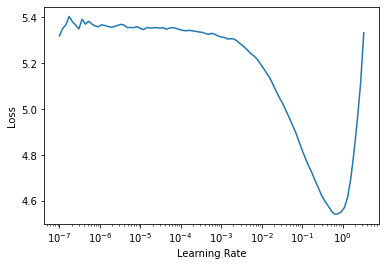

In [9]:
learn.lr_find()

This gives us a graph of the optimal learning rate ... which is the point where the graph really dives downward (`1e-02` or so). Again, there's much more on picking and learning rates in the fast.ai course.

Now we can train the Language Model. (Essentailly, we're training it to be good at guessing the *next word* in a sentence, given all of the previous words.)

The variabales we're passing are `1` to just do one cycle of learning, the learning rate of `1e-2`, and some momentum settings we won't get into here -- but these are pretty safe. 

In [10]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.351998,3.665022,0.329578,39.056980,00:07


In [11]:
learn.fit_one_cycle(1, 1e-2)


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.526507,3.129211,0.385308,22.855944,00:07


To complete the fine-tuning, we "unfreeze" the original wikitext-103 language model and let our new training efforts work their way into the original neural network.

Notice that we've booped the learning rate down by an order of magnitude. This a good idea... the Fast.ai course will tell you why.

In [12]:
# This takes a couple of minutes!
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.007218,2.572195,0.467882,13.094530,00:08
1,2.710794,2.423499,0.495709,11.285276,00:08


While our accuracy may _seem_ low ... in this case it means the language model correctly guessed the next word in a sentence more than 1/3 of the time. That's pretty good! And we can see that even when it's wrong, it makes some pretty "logical" guesses. 

Let's give it a starting phrase and see how it does:


In [13]:
TEXT = "We must stop"
N_WORDS = 40
N_SENTENCES = 3

print("\n\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

We must stop our movement . Every one will show up . Support your country , shape your future . We can not afford a broken promises , and we need to know what your future will be .

We must stop foreign interference in our elections by counting on our foreign nations to help us reach our goal . Even more finishes with Joe Biden 's signature , and even more and more than ever , all

We must stop in Southampton , New York , but we need your help . This is why we need to have a united American people and American people to fight for YOU . 




Remember, these are not real ... they were _generated_ by the model when it tried to guess each of the next words in the sentence! Generating text like this is not why we made the language model (though you can see where text-generation AI starts from!)

Also note that the model is often crafting the response _in the form of a tweet!_

We now save the model's encoder, which is the mathematical representation of what the language model "understands" about English patterns infused by our political_ads.

In [14]:
learn.save_encoder('fine_tuned_enc')  

## Building the classifier model

This is the model that will use our language model **and** the hand-coded political ads to guess if new ads are probably from Democrats, Republicans or sosething else.

We'll create a new data loader that _does_ keeps track of the labels there ("liberal", "conservative", or "other"). We also pass in the `vocab` -- which is the list of the most useful words from the language model.

In [16]:
data_for_classification = TextDataLoaders.from_csv(path=path, csv_fname='data/partisanship_model_training_data_3000.csv', vocab=data_for_language_model.vocab, text_col='ad_creative_body', label_col='partisanship')

We can then create a model to classify political_ads. You can see that in the next two lines we include the processed, hand-coded political_ads (`data_for_classification`), the original Wikitext model (`AWD_LSTM`), and the knowledge we saved after infusing the language model with political_ads (`fine_tuned_enc`).

In [17]:
learn = text_classifier_learner(data_for_classification, AWD_LSTM, drop_mult=0.5, metrics=[accuracy])
learn.load_encoder('fine_tuned_enc');

With neural networks, there are lots of tweaks you can adjust — known as "hyperparameters" — such as learning rate and momentum. The fast.ai defaults are pretty great, and the tools it has for finding the learning rate are super useful. I'm going to skip those details here for now. There's more to learn at [qz.ai](https://qz.ai) or at the [this great fast.ai course](https://course.fast.ai/).

In [18]:
learn.fit_one_cycle(2, 1e-2)

learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2))

learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.792990,0.562693,0.765000,00:05
1,0.631284,0.286538,0.908333,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.587954,0.335500,0.901667,00:05
1,0.471104,0.243079,0.908333,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.383035,0.250775,0.925000,00:06
1,0.302729,0.170274,0.948333,00:06


Let's give it an example ....

In [19]:
example = "We must elect Joe Biden as President this November 6"
learn.predict(example)

('liberal', tensor(1), tensor([0.2111, 0.7457, 0.0432]))

Robot 🤖 says `liberal`. We agree?

Let's save our work.

## Saving to Google Drive

At present, your Google Colaboratory Notebook disappears when you close it — along with all of your data. If you'd like to save your model to your Google Drive, run the following cell and grant the permissions it requests.

In [ ]:
## THIS CELL WILL ALLOW GOOGLE COLAB USERS SAVE MODELS TO YOUR GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


root_dir = "/content/gdrive/My Drive/"


In [21]:
# # if you don't want to save to Google drive, remove the # on the line below, and run thatinstead
# root_dir = './'

The next line will save everything we need for predictions to a file to your Google Drive in the `ai-workshops` folder.

In [22]:
save_path = Path(root_dir + 'ai-texts/')
save_path.mkdir(parents=True, exist_ok=True)
learn.path = save_path
learn.export()

Later, to load the model into your code, connect to your Google drive using the same block above that starts `from google.colab import drive ...` and then run this:
    

In [23]:
# load the model from the 'export.pkl' file on your Google Drive
learn = load_learner(save_path/"export.pkl")  

In [27]:
example = "Sleepy Joe will DESTROY our cities. We back the blue!"
learn.predict(example)

('conservative', tensor(0), tensor([0.6198, 0.3695, 0.0107]))

*Discussion Questions*

1.   What would happen if we fed this model tweets?
2.   To create the training dataset, I didn't hand label ads. I hand-picked a few big partisan advertisers, as a shortcut. Can you think of an example where you could maybe do something similar?
3.   What are some possible shortcomings that a "shortcut" like that might cause? How would you look for those?
4.   So far we've learned to categorize images and to categorize the text of political ads. What do we think would happen if we tried to categorize the *images* from political ads by partisanship?

